# Brazilian E-commerce Analysis 

## 1. Setup 
- Import libraries (pandas, matplotlib, seaborn, sqlite3)
- Connecting to database 

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sqlite3

conn = sqlite3.connect('ecommerce.db')

## 2. Revenue per Category 

First step into the analysis we're diving into understanding the market: identifying which categories based off the different 71 available are the most profitable.  

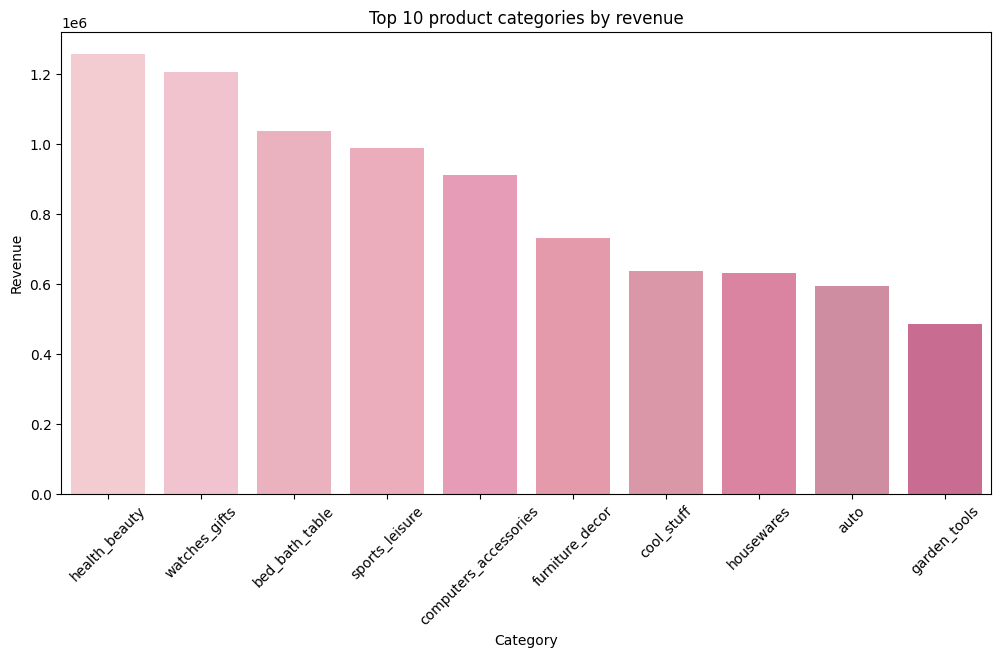

In [40]:
query = """
SELECT SUM(oi.price) as total_revenue, t.product_category_name_english AS category FROM order_items oi 
JOIN products p ON p.product_id = oi.product_id 
JOIN translation t ON p.product_category_name = t.product_category_name
WHERE p.product_category_name IS NOT NULL 
GROUP BY t.product_category_name_english
ORDER BY total_revenue DESC
LIMIT 10;
"""

revenue_category = pd.read_sql_query(query, conn)

# graphing 
# firstly, we're choosing a palette for all graphs: 
soft_pink_palette = [
    "#F9C6CE",  
    "#F7BBCB",
    "#F4A7B9",
    "#F5A1B5",
    "#F28FB2",
    "#F28DA5",
    "#E58CA2",
    "#E8769C",
    "#D9829D",
    "#D95C8E"   
]

plt.figure(figsize=(12, 6))
sns.barplot(data = revenue_category.head(10), x = 'category', y = 'total_revenue', palette = soft_pink_palette, hue='category', legend=False)
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.xticks(rotation = 45)
plt.title("Top 10 product categories by revenue")
plt.show()

Noticeable differences exist within each category, having health_beauty items take most of the product revenue along with watches_gifts. It's important to notice that these 10 categories are the ones with the highest revenue incoming, out of all 71 product categories available.  

## 3. Revenue per Customer 

In this section, we're analyzing revenue per customer. 

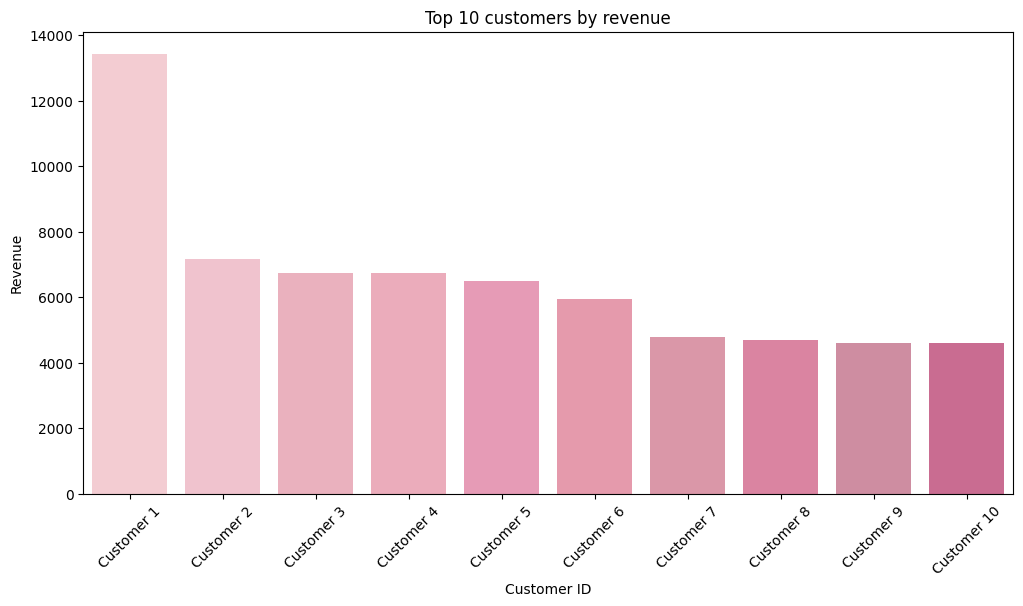

In [41]:
query = """
SELECT c.customer_id, SUM(oi.price) AS prod_revenue FROM customers c
JOIN orders o ON c.customer_id = o.customer_id 
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_id ORDER BY prod_revenue DESC 
LIMIT 10;
"""

revenue_customer = pd.read_sql_query(query, conn)
# renaming customer IDs 
revenue_customer = revenue_customer.reset_index(drop=True)  # reset index to 0,1,2...
revenue_customer['customer_label'] = revenue_customer.index + 1  # 1,2,3...
revenue_customer['customer_label'] = 'Customer ' + revenue_customer['customer_label'].astype(str)

plt.figure(figsize=(12,6))
sns.barplot(data = revenue_customer, x = 'customer_label', y = 'prod_revenue', palette = soft_pink_palette, hue = 'customer_label', legend = False)
plt.xlabel("Customer ID")
plt.ylabel("Revenue")
plt.xticks(rotation = 45)
plt.title("Top 10 customers by revenue")
plt.show()

It is also known that each customer carries out only one purchase, therefore it's clear that Customer 1 made a single purchase of over $10,000, while other top 10 clients have purchases ranging from above $4,000 up to more than $7,000. 

## 4. Percentage of Revenue per Category of each Top Seller

In this section, we analyze the revenue per seller and it's total market share on each category. 

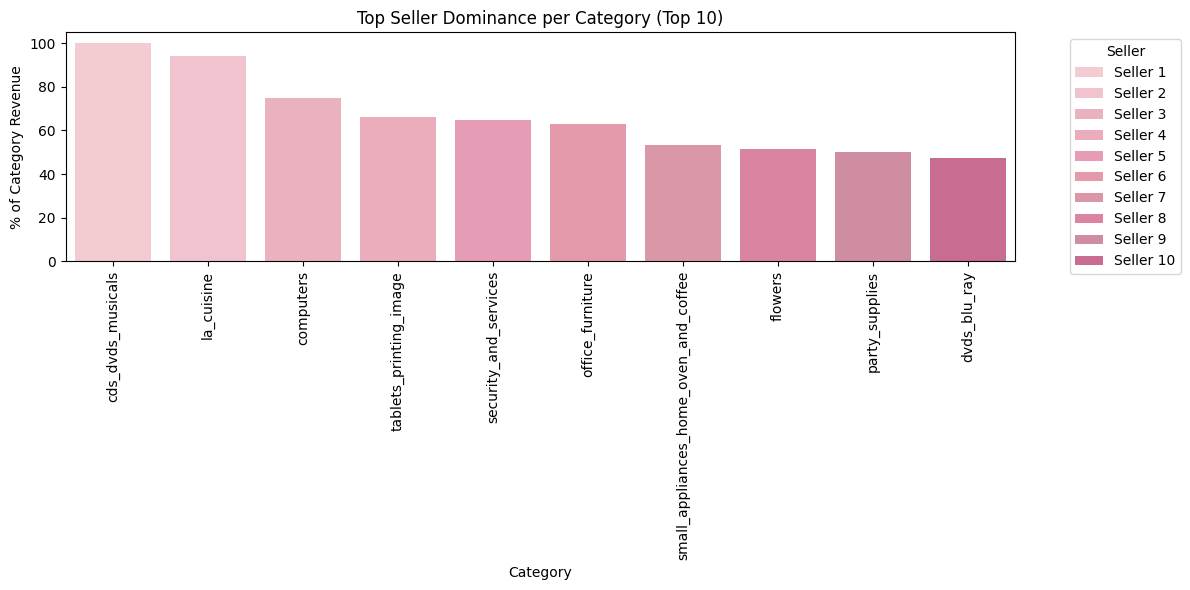

In [42]:
query = """
WITH seller_category_revenue AS (
    SELECT 
        t.product_category_name_english AS category,
        oi.seller_id,
        SUM(oi.price) AS seller_revenue
    FROM order_items oi
    JOIN products p ON oi.product_id = p.product_id
    JOIN translation t ON p.product_category_name = t.product_category_name
    GROUP BY t.product_category_name_english, oi.seller_id
),
category_total_revenue AS (
    SELECT 
        category,
        SUM(seller_revenue) AS total_category_revenue
    FROM seller_category_revenue
    GROUP BY category
)
SELECT
    scr.category,
    scr.seller_id,
    scr.seller_revenue,
    ctr.total_category_revenue,
    ROUND(100.0 * scr.seller_revenue / ctr.total_category_revenue, 2) AS seller_pct_of_category
FROM seller_category_revenue scr
JOIN category_total_revenue ctr ON scr.category = ctr.category
WHERE scr.seller_revenue = (
    SELECT MAX(s2.seller_revenue)
    FROM seller_category_revenue s2
    WHERE s2.category = scr.category
)
ORDER BY seller_pct_of_category DESC;
"""
# we're limiting the categories to the top 10 with highest revenue from the top seller. 

top_seller_category = pd.read_sql_query(query, conn)

top_seller_category = top_seller_category.head(10)

# Create friendly seller labels (optional)
top_seller_category = top_seller_category.reset_index(drop=True)
top_seller_category['seller_label'] = 'Seller ' + (top_seller_category.index + 1).astype(str)

# Plot chart
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_seller_category,
    x='category',                
    y='seller_pct_of_category',         
    hue='seller_label',          
    palette=soft_pink_palette,
    legend='brief'
)

plt.xlabel("Category")
plt.ylabel("% of Category Revenue")
plt.title("Top Seller Dominance per Category (Top 10)")
plt.xticks(rotation=90)
plt.legend(title="Seller", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

It's noticeable how Seller 1 dominates the category of CDs, DVDs and musicals, and up to Seller 8, most sellers dominate their market with over 50% of it's revenue each. This is interesting, as it demonstrate how each individual seller focuses on a specific category of the market in order to increase their sales and ultimately make the most sales on their specific category.  

## 5. Revenue over Time 

In this section, we will now finally analyze revenue over time, considering the time frame available from the database, from september 2016 up to september 2018.

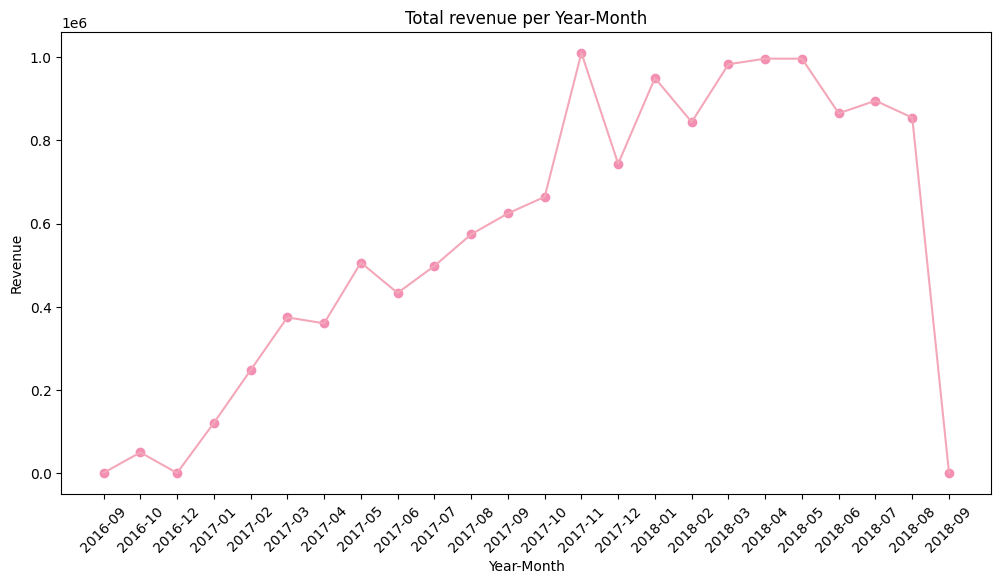

In [43]:
query = """
SELECT SUM(oi.price) as total_revenue, strftime('%Y-%m', order_purchase_timestamp) AS year_month FROM order_items oi 
JOIN orders o ON oi.order_id = o.order_id 
GROUP BY year_month 
ORDER BY year_month;
"""

revenue_time = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
plt.plot(revenue_time['year_month'], revenue_time['total_revenue'], color = soft_pink_palette[2])
plt.scatter(revenue_time['year_month'], revenue_time['total_revenue'], color = soft_pink_palette[4])
plt.xticks(rotation= 45)
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.title("Total revenue per Year-Month")
plt.show()

In the graphic it's noticeable a common product-life cycle, most likely focusing on the product introduction and launching during late 2016, and product maturity during late 2017 and early 2018, finally ending during september 2018 with a sudden crash in revenue for the business, potentially leading to bankrupcy or an unexpected closing. 

## 6. Summary Insights
- Market Concentration by Category: Revenue is concentrated mainly in categories such as health_beauty and watches_gifts. These top categories drive the majority of the business’s overall profitability.  
- Customer Purchasing Behavior: Each customer made only one purchase during the available time period; however, several high-value customers generated significant revenue individually.  
- Seller Dominance: Most sellers dominate their respective categories, often capturing over 50% of category revenue. This suggests a specialization strategy, where sellers focus on niches to maximize revenue.  
- Revenue Over Time: Revenue trends follow a typical product life cycle, peaking during late 2017 and early 2018, then experiencing a sharp decline in September 2018.  

### Key Takeaways
- Focus on high-performing categories to sustain and grow revenue.  
- Encourage sellers to specialize strategically in categories where they have expertise and can dominate.  
- Monitor revenue trends over time to identify seasonal effects or product lifecycle impacts.